# Import Library

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.optimize as opt

# Read & Analyze Data

In [2]:
file_path = 'training_data.txt'
df = pd.read_csv(file_path,header=None, names=["x1","x2", "result"])
df.head(5)


,x1,x2,result
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
df.describe()

,x1,x2,result
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


In [4]:
"Split data"
X_ = df.iloc[:, :-1] #Feature
y_ = df.iloc[:,   2] #Lable

X = X_ #Feature
y = y_ #Lable
m = len(y)

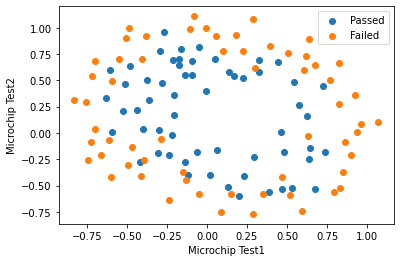

In [5]:
mask = y == 1

passed = plt.scatter(X[mask]["x1"].values, X[mask]["x2"].values) # Sự phân tán của x1 so vs x2 khi đạt chuẩn
failed = plt.scatter(X[~mask]["x1"].values, X[~mask]["x2"].values) # Sự phân tán của x1 so vs x2 khi không đạt chuẩn


plt.xlabel('Microchip Test1')
plt.ylabel('Microchip Test2')

plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()


* Comment

    - Tại đây ta để ý rằng nếu như boundary là 1 đường thẳng thì không thể nào dự đoán chính xác được

    - Như trên hình thì ta cần 1 vòng tựa như đường tròn để có thể phân tách thành 2 miền 1/0

    

# Help Functions

#### Map features

In [6]:
"Raw features mapped to new feature domain consists of 28 dimensions"
def map_feature(x1, x2):
#   Returns a new feature array with more features, comprising of 
#   x1, x2, x1.^2, x2.^2, x1*x2, x1*x2.^2, etc.

    degree = 6
    out = np.ones([len(x1), int((degree + 1) * (degree + 2) / 2)])
    idx = 1

    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            a1 = x1 ** (i - j)
            a2 = x2 ** j
            out[:, idx] = a1 * a2
            idx += 1

    return out

X = map_feature(X.iloc[:,0],X.iloc[:,1])

In [7]:
"Sigmoid Function"

def sigmoid(x):
  return 1/(1+np.exp(-x))


In [8]:
class LogisticRegression:
    def __init__(self, alpha=0.001, iters=1000, lamda = 1, verbose=False):
        self.alpha = alpha
        self.iters = iters
        self.lamda = lamda
        self.verbose = verbose
        self.theta = None
        
    def CostFunction(self, X, y,theta, lamda):
        m = len(y)
        J = (-1/m) * (y.T @ np.log(sigmoid(X @ theta)) + (1 - y.T) @ np.log(1 - sigmoid(X @ theta)))
        reg = (lamda/(2*m)) * (theta[1:].T @ theta[1:])
        J = J + reg
        return J
    def gradient(self, X, y, theta, lamda):
        h_theta = X@theta
        loss = h_theta - y
        
        dJ = (1/m) * X.T @ (sigmoid(h_theta) - y)
        dJ[1:] =  dJ[1:] + (lamda / m) * theta[1:]
        
        J = self.CostFunction(X,y,theta,lamda)

        return (J, dJ)
    def gradient_descent(self, X, y,lamda):
        X = np.c_[np.ones(len(X),dtype='int64'), X]
        theta = np.zeros(X.shape[1])
        print(f'The total of training sample: {len(y)}')

        for i in range(self.iters):
            #todo
            J, dJ = self.gradient(X,y,theta,lamda)
            #todo
            theta = theta - self.alpha*dJ
            if self.verbose:
                print(f'Iter {i + 1}, loss = {self.calculate_absolute_error(X, y, theta)}')
        return theta
    
    def fit(self, X, y):
        self.theta = self.gradient_descent(X, y,self.lamda)
    
    def predict(self, X):
        results = []
        for Xi in X:
            exponent = Xi@self.theta[1:] + self.theta[0]
            h_theta = sigmoid(exponent)
            if(h_theta >= 0.5):
                results.append(1)
            else: 
                results.append(0)
            
        return results

# Main Fuction

## Train Model

In [9]:
"Read the training configuration from file config.json."
with open('config.json',) as f:
    configs = json.load(f)

"Train model"
model = LogisticRegression(alpha= configs['Alpha'], iters=configs['NumIter'], lamda=configs['Lambda'], verbose=False)

"Find theta"
model.fit(X, y)


The total of training sample: 118


## Visualize Model

In [10]:

def mapFeatureForPlotting(X1, X2):
    degree = 6
    out = np.ones(1)
    for i in range(1, degree+1):
        for j in range(i+1):
            out = np.hstack((out, np.multiply(np.power(X1, i-j), np.power(X2, j))))
            
    return out


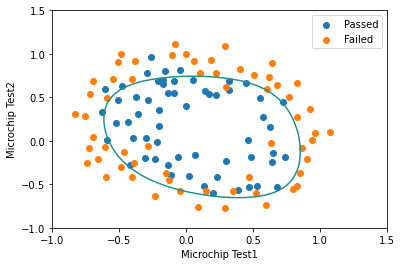

In [11]:

"Chọn ra 2 domain u,v tương ứng vs miền giá trị của x1,x2"
u = np.linspace(-1, 1.5, 50) 
v = np.linspace(-1, 1.5, 50)


"Tính giá trị h_theta cho từng bộ trong u,v"
z = np.zeros((len(u), len(v))) 
for i in range(len(u)):
    for j in range(len(v)):
        z[i,j] = np.dot(mapFeatureForPlotting(u[i], v[j]), model.theta[1:]) + model.theta[0] 

"Vẽ đồ thị"
mask = y == 1
X = df.iloc[:,:-1]
passed = plt.scatter(X_[mask]["x1"], X_[mask]["x2"])
failed = plt.scatter(X_[~mask]["x1"], X_[~mask]["x2"])

plt.contour(u,v,z,0)

plt.xlabel('Microchip Test1')   
plt.ylabel('Microchip Test2')
plt.legend((passed, failed), ('Passed', 'Failed'))
plt.show()

- Comment:

    Tại đây ta thấy vùng dữ liệu đã được khoanh vùng phân chia khá chuẩn xác, tuy nhiên vẫn còn một số ngoại lệ, nhưng không đáng kể so với tổng thể --> mô hình chấp nhận được

## Predict Sample


In [12]:
sample = [[0.016705,-0.4042]]


n = len(sample)
sample =  np.array(sample).T
sample_map_feature = map_feature(sample[0],sample[1])
y_predict = model.predict(sample_map_feature)
for i in range(n):
    print(y_predict[i], sep=', ')


1


## Calculate accuracy of training data set

In [13]:
X = map_feature(X_.iloc[:,0],X_.iloc[:,1])
y = np.c_[y_]

"Now we calculate accuracy of traning set data with model had been learned above"
pred = [sigmoid(np.dot(X, model.theta[1:]) + model.theta[0]) >= 0.5]
accuracy = np.mean(pred == y.flatten()) * 100

print("Accuracy:", accuracy)

Accuracy: 83.05084745762711


## Save Results


In [14]:
"Save model to file model.json"
with open('model.json', 'w') as f:
    #todo
    json.dump({'theta: ': list(model.theta)}, f)

"Save  accuracy to file accuracy.json"
with open('accuracy.json', 'w') as f:
    #todo
    json.dump({'accuracy: ': accuracy}, f)
